# Final project on 'Data Science' - HIT

### Writing the project: <br/>
Nave Shimoni  <br/>
Itay galili

### Research question:  <br/>
Is it possible to anticipate the decrease in car's value in 5 years based on ZapCars?

# Crawling

In [1]:
from selenium import webdriver
from bs4 import BeautifulSoup
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
%matplotlib inline
import time
import json
import requests
import re

### Test before performing <br/>
In testing before the crawling we saw that there are about 4700 cars, each HTML page on the site contains 20 cars, so about 236 iterations are required for each page, in addition we saw that the difference between pages is its URL extension (the site worked differently at the beginning of the project and there was a need for selinium, but after a change - we made adjustments)

In [2]:
base_url = "https://www.zapcars.co.il/"
tab_results = []

for page_number in tqdm(range(1, 236)):
    url = base_url + "cars/?page=" + str(page_number)
    response = requests.get(url)
    if response.status_code == 200:
        soup = BeautifulSoup(response.content, "html.parser")
        tab_results.extend(soup.find_all("div", attrs={"class": "resultsListItem"}))
    else:
        print("Failed to fetch page", page_number)

print(tab_results)

100%|██████████| 235/235 [05:06<00:00,  1.30s/it]
IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Let's see how many URLs of HTML pages for cars we managed to collect:

In [3]:
print(len(tab_results))



4700


In [4]:
links_to_pages = []
for tag in tab_results:
    a_tag = tag.find("a")
    if a_tag is not None and 'href' in a_tag.attrs:
        links_to_pages.append(a_tag['href'])

links_to_pages = [base_url + link for link in links_to_pages]
print(links_to_pages)

with open("links_to_pages.json", "w") as f:
    json.dump(links_to_pages, f)

['https://www.zapcars.co.il//listing/d63f1ac8-bdf5-4e3a-ba9e-d1c6212f0245/', 'https://www.zapcars.co.il//listing/d09861c7-3bf8-46b3-8498-dfa28c8259a1/', 'https://www.zapcars.co.il//listing/b2cf2b3c-7639-445c-8c82-8e553d0992b4/', 'https://www.zapcars.co.il//listing/d6b75a02-5cd1-438d-a2a0-431a9f5db707/', 'https://www.zapcars.co.il//listing/130268fe-b9f5-41fd-b279-fde3f0bbc7e7/', 'https://www.zapcars.co.il//listing/613945c7-81d9-48a4-9553-44e2a17ff23b/', 'https://www.zapcars.co.il//listing/d587cfd6-2edd-4d10-97c1-f2b065117ed9/', 'https://www.zapcars.co.il//listing/03d90abc-d674-4b56-b7e9-18ef4b32d974/', 'https://www.zapcars.co.il//listing/e9139b09-c6a4-4004-8b9f-204f91896a9d/', 'https://www.zapcars.co.il//listing/ce9c774e-8157-42a4-803d-4a0d16864179/', 'https://www.zapcars.co.il//listing/240aaedd-4934-4aa0-a943-9a80f372cc9e/', 'https://www.zapcars.co.il//listing/372cc3f9-32c1-482c-b729-049102b853d9/', 'https://www.zapcars.co.il//listing/5350f405-d840-49ab-948e-b86d5e4b0e3a/', 'https://ww

Once we have received all the addresses of each page, we will go through each page and take the relevant information from it. We saw that there are 12 columns of information that can be a component of a car price. <br/>
note:
* We checked that the vehicle still existed, because it happened to us that a car page was closed while working and the running stopped (with response = 200).
* We decided to perform health checks on the resulting elements at this stage (element type, end cases that cost us, transfer from string to int, etc.).
* We used 'tqdm' to control the workflow (which took almost an hour!).


In [11]:
company=[]
car_type=[]
year=[]
engine_volume=[]
km=[]
hand=[]
gear_box=[]
color=[]
current_owner=[]
price=[]
gas=[]
horse_power=[]

for url in tqdm(links_to_pages):
    response = requests.get(url)
    if response.ok:
        soup2 = BeautifulSoup(response.content)
        mtags_span=soup2("span")

        #year
        mtag1=re.findall('\d+', mtags_span[15].get_text())
        if mtag1:
            year.append(int(mtag1[0]))
        else:
            year.append(None)

        #color
        mtag2=soup2.find("div",attrs={"id":"carColor"})
        if mtag2:
            mtag2 = mtag2.get_text().strip()
            color.append(mtag2)
        else:
            color.append(None)

        #company
        mtag3=mtags_span[10].get_text().strip()
        if mtag3:
            company.append(mtag3)
        else:
            company.append(None)

        #car_type
        mtag4=mtags_span[12].get_text().strip().lstrip('\u200f')
        if mtag4:
            car_type.append(mtag4)
        else:
            car_type.append(None)

        #engine_volume
        mtag5=soup2.find("div",attrs={"id":"carDetailsEngineVolume"})
        if mtag5:
            mtag5 = int(re.sub("[^0-9]", "", mtag5.get_text()))
            engine_volume.append(mtag5)
        else:
            engine_volume.append(None)

        #hand
        mtag6=soup2.find("div",attrs={"id":"carDetailsHand"})
        isNew = 1 if "רכב חדש" in mtag6.get_text() else 0
        mtag6 = re.sub("[^0-9]", "", mtag6.get_text().strip())
        if mtag6:
            hand.append(int(mtag6))
        else:
            hand.append(None)

        #km
        if isNew==0:
            mtag7 = re.sub("[^0-9]", "", mtags_span[16].get_text())
            if mtag7:
                km.append(int(mtag7))
            else:
                km.append(None)    
        else:
            mtag7=0
            km.append(mtag7)

        #gear_box
        mtag8=soup2.find("div",attrs={"id":"carDetailsAutomatic"})
        if mtag8:
            mtag8 = mtag8.get_text().strip()
            gear_box.append(mtag8)
        else:
            gear_box.append(None)

        #current_owner
        mtag9=soup2.find("div",attrs={"id":"carOnershipType"})
        if mtag9:
            mtag9 = mtag9.get_text().strip()
            current_owner.append(mtag9)
        else:
            current_owner.append(None)

        #gas
        mtag10=soup2.find("div",attrs={"id":"carDetailsGasType"})
        if mtag10:
            mtag10 = mtag10.get_text().strip()
            gas.append(mtag10)
        else:
            gas.append(None)

        #price
        mtag11=soup2.find("div",attrs={"id":"carPrice"})
        if mtag11:
            mtag11 = int(re.sub("[^0-9]", "", mtag11.get_text()))
            price.append(mtag11)
        else:
            price.append(None)

        #horse_power
        mtag12=soup2.find("div",attrs={"id":"carDetailsHorsepower"})
        if mtag12:
            mtag12 = int(mtag12.get_text())
            horse_power.append(mtag12)
        else:
            horse_power.append(None)



100%|██████████| 4700/4700 [59:55<00:00,  1.31it/s]   


In [3]:
df=pd.DataFrame({"company":company,
                 "car type":car_type,
                 "year":year,
                 "engine volume":engine_volume,
                 "km":km,
                 "hand":hand,
                 "gear box":gear_box,
                 "color":color,
                 "current owner":current_owner,
                 "price":price,"gas":gas,
                 "horse power":horse_power})

df.to_csv('data_frame.csv', index=False)

NameError: name 'company' is not defined

Mazel Tov! We have a data frame with 12 columns and 4700 rows, in total we have 56,400 data units. <br/> We will save everything on a CSV table for use at other times (so that we don't have to wait all the time again).

In [8]:
#This line below is the temporary run in order to get the df
df=pd.read_csv("data_frame.csv")

pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.max_rows', None)     # Show all rows
pd.set_option('display.width', None) 
df

company           car type  year  engine volume      km  hand  \
0                 הונדה               HR-V  2019           1498  138054     1   
1              מיצובישי              אטראז  2020           1193   34969     1   
2                 אאודי                 A6  2017           1798  118000     3   
3                 מאזדה                  3  2020           1998   76677     1   
4                 מאזדה                  2  2023           1496       0     1   
5                שברולט          אקווינוקס  2019           1490   44000     1   
6                  פיאט                500  2023              0       0     1   
7                 סקודה            אוקטביה  2019            999  123264     1   
8              מיצובישי         ספייס סטאר  2021           1193   23727     1   
9                   קיה             פיקנטו  2020           1248   65676     1   
10                סקודה             קודיאק  2018           1968   98000     1   
11               יונדאי              אקסנט  2020           1368   82318     1   
12               יונדאי                I10  2021           1197   37251     1   
13               שברולט              ספארק  2020           1399   72093     1   
14                 סיאט               לאון  2016           1798  158000     2   
15                  קיה             פיקנטו  2019           1248  107892     1   
16                  קיה            ספורטאז  2017           1999  112265     1   
17                 סיאט             איביזה  2018            999  107724     1   
18               יונדאי                I10  2020           1197  111581     1   
19                פיג'ו               5008  2020           1199   59660     1   
20               יונדאי                I20  2020            998   96858     1   
21                  קיה             פיקנטו  2021           1248   67445     1   
22               יונדאי              טוסון  2023           1598       0     1   
23               שברולט             קפטיבה  2017           1956   74000     2   
24               סובארו            אימפרזה  2018           1600  168500     2   
25             מיצובישי         ספייס סטאר  2021           1193   24731     1   
26               יונדאי             איוניק  2020           1580  103285     1   
27              קרייזלר              רנגלר  2021           1995   25000     2   
28                  קיה             פיקנטו  2020           1248   86957     1   
29                אאודי                 Q3  2016           1984  153000     1   
30                פיג'ו               2008  2018           1199   66450     1   
31                סקודה             קודיאק  2019           1968   95000     1   
32                 סיאט               לאון  2017           1984  100000     1   
33               יונדאי             איוניק  2020           1580  108000     1   
34               טויוטה             קורולה  2019           1798  116890     1   
35               טויוטה             קורולה  2019           1798   90498     1   
36                מרצדס                CLA  2023           1332       0     1   
37               יונדאי              טוסון  2018           1999   64815     1   
38               יונדאי             איוניק  2019           1580  113168     1   
39              סיטרואן                 C3  2019           1199   44150     2   
40               סובארו                 XV  2018           1600   98000     1   
41                פיג'ו               3008  2020           1499  105777     2   
42                סקודה              סקאלה  2020            999   81496     1   
43               שברולט          אקווינוקס  2017           1490   50000     1   
44                פיג'ו               3008  2020           1598   50258     1   
45             מיצובישי             אקליפס  2019           1499   32316     1   
46                מרצדס                GLA  2023           1332       0     1   
47               טויוטה             קורולה  2020           1798   53377     1   
48                 ג'יפ              רנגלר  202

In [9]:
df.shape

(4699, 12)

# Data handling <br/>
Before we begin, here are a number of treatments that have already been performed:
* Any element that has no data - we put "None" instead.
* We saw that new cars do not indicate the vehicle's km, so we proactively put 0 (note the "isNew" flag in the hand number).
* We performed casting on strings and turned them into int.

Let's start with simple data verification commands.

In [10]:
df.describe(include="all")

company car type         year  engine volume             km  \
count     4699     4699  4699.000000    4699.000000    4699.000000   
unique      50      317          NaN            NaN            NaN   
top        קיה  אוקטביה          NaN            NaN            NaN   
freq       657      265          NaN            NaN            NaN   
mean       NaN      NaN  2019.350287    1592.007448   77694.037455   
std        NaN      NaN     1.806133     561.193515   42871.692416   
min        NaN      NaN  2005.000000       0.000000       0.000000   
25%        NaN      NaN  2019.000000    1248.000000   50011.500000   
50%        NaN      NaN  2019.000000    1499.000000   80000.000000   
75%        NaN      NaN  2020.000000    1977.000000  105000.000000   
max        NaN      NaN  2023.000000    6162.000000  499999.000000   

               hand  gear box     color current owner          price    gas  \
count   4699.000000      4699      4699          4695    4699.000000   4699   
unique          NaN         2        64             5            NaN      5   
top             NaN  אוטומטית  שנהב לבן          חברה            NaN  בנזין   
freq            NaN      4638      1318          1362            NaN   3972   
mean       1.182166       NaN       NaN           NaN  130006.130028    NaN   
std        0.492184       NaN       NaN           NaN   87389.758794    NaN   
min        0.000000       NaN       NaN           NaN    9900.000000    NaN   
25%        1.000000       NaN       NaN           NaN   84831.000000    NaN   
50%        1.000000       NaN       NaN           NaN  109180.000000    NaN   
75%        1.000000       NaN       NaN           NaN  139154.500000    NaN   
max        7.000000       NaN       NaN           NaN  999000.000000    NaN   

        horse power  
count   4699.000000  
unique          NaN  
top             NaN  
freq            NaN  
mean     148.696744  
std       59.728185  
min       45.000000  
25%      115.000000  
50%      141.000000  
75%      159.000000  
max      551.000000

The ranges of numbers indicated here are appropriate and logical (for example, it makes sense that vehicle years range from 2005 to 2023)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4699 entries, 0 to 4698
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   company        4699 non-null   object
 1   car type       4699 non-null   object
 2   year           4699 non-null   int64 
 3   engine volume  4699 non-null   int64 
 4   km             4699 non-null   int64 
 5   hand           4699 non-null   int64 
 6   gear box       4699 non-null   object
 7   color          4699 non-null   object
 8   current owner  4695 non-null   object
 9   price          4699 non-null   int64 
 10  gas            4699 non-null   object
 11  horse power    4699 non-null   int64 
dtypes: int64(6), object(6)
memory usage: 440.7+ KB


In [12]:
df.isnull().sum()

company          0
car type         0
year             0
engine volume    0
km               0
hand             0
gear box         0
color            0
current owner    4
price            0
gas              0
horse power      0
dtype: int64

There are 'NaN' in 'current owner', and you can also see that this column is relatively the 'most problematic': <br/>
(We will turn each NaN into a "-").

In [13]:
df['current owner'].value_counts()

חברה      1362
ליסינג    1191
-         1119
פרטי       775
השכרה      248
Name: current owner, dtype: int64

There are a lot of ' - ' in this column (1119).

In [14]:
df["current owner"].fillna('-',inplace=True)
df['current owner'] = df['current owner'].replace('-', 'not specify')
df['current owner'] = df['current owner'].replace('חברה', 'company')
df['current owner'] = df['current owner'].replace('ליסינג', 'leasing')
df['current owner'] = df['current owner'].replace('פרטי', 'private')
df['current owner'] = df['current owner'].replace('השכרה', 'rent')


df['current owner'].value_counts()

company        1362
leasing        1191
not specify    1123
private         775
rent            248
Name: current owner, dtype: int64

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4699 entries, 0 to 4698
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   company        4699 non-null   object
 1   car type       4699 non-null   object
 2   year           4699 non-null   int64 
 3   engine volume  4699 non-null   int64 
 4   km             4699 non-null   int64 
 5   hand           4699 non-null   int64 
 6   gear box       4699 non-null   object
 7   color          4699 non-null   object
 8   current owner  4699 non-null   object
 9   price          4699 non-null   int64 
 10  gas            4699 non-null   object
 11  horse power    4699 non-null   int64 
dtypes: int64(6), object(6)
memory usage: 440.7+ KB


In [16]:
print(df['company'].value_counts())

קיה                  657
סקודה                640
יונדאי               474
מיצובישי             384
פיג'ו                322
טויוטה               268
אאודי                246
שברולט               192
סיאט                 176
ניסאן                167
מאזדה                157
סיטרואן              113
מרצדס                102
ב מ וו                87
פולקסווגן             71
רנו                   68
סובארו                61
ג'יפ                  49
אם.ג'י - ‏MG          38
פורד                  36
לנד רובר              33
וולבו                 30
צ'רי                  28
אופל                  27
פיאט                  27
קאדילאק               25
דאצ'יה                25
סוזוקי                24
טסלה                  23
יגואר                 21
הונדה                 20
אלפא רומיאו           19
איסוזו                13
קרייזלר               12
לקסוס                 12
די. אס - ‏DS          11
אינפיניטי              7
פורשה                  6
סמארט                  5
מזראטי                 5


In [17]:
df['company'] = df['company'].replace('קיה', 'KIA')
df['company'] = df['company'].replace('סקודה', 'Skoda')
df['company'] = df['company'].replace('יונדאי', 'Hyudai')
df['company'] = df['company'].replace('מיצובישי', 'Mitsubishi')
df['company'] = df['company'].replace("פיג'ו", 'Peugoet')
df['company'] = df['company'].replace('טויוטה', 'Toyota')
df['company'] = df['company'].replace('אאודי', 'Audi')
df['company'] = df['company'].replace('שברולט', 'Chevrolet')
df['company'] = df['company'].replace('סיאט', 'Seat')
df['company'] = df['company'].replace('ניסאן', 'Nissan')
df['company'] = df['company'].replace('מאזדה', 'Mazda')
df['company'] = df['company'].replace('סיטרואן', 'citroen')
df['company'] = df['company'].replace('מרצדס', 'marcedes')
df['company'] = df['company'].replace('ב מ וו', 'BMW')
df['company'] = df['company'].replace('פולקסווגן', 'volkswagen')
df['company'] = df['company'].replace('רנו', 'renault')
df['company'] = df['company'].replace('סובארו', 'subaru')
df['company'] = df['company'].replace("ג'יפ", 'jeep')
df['company'] = df['company'].replace("אם.ג'י - ‏MG", 'MG')
df['company'] = df['company'].replace('פורד', 'pord')
df['company'] = df['company'].replace('לנד רובר', 'landrover')
df['company'] = df['company'].replace('וולבו', 'volvo')
df['company'] = df['company'].replace("צ'רי", 'chery')
df['company'] = df['company'].replace('אופל', 'opel')
df['company'] = df['company'].replace('פיאט', 'piat')
df['company'] = df['company'].replace('קאדילאק', 'cadillac')
df['company'] = df['company'].replace("דאצ'יה", 'dacia')
df['company'] = df['company'].replace('סוזוקי', 'suzuki')
df['company'] = df['company'].replace('טסלה', 'tesla')
df['company'] = df['company'].replace('יגואר', 'jaguar')
df['company'] = df['company'].replace('הונדה', 'honda')
df['company'] = df['company'].replace('אלפא רומיאו', 'alfa romeo')
df['company'] = df['company'].replace('איסוזו', 'isuzu')
df['company'] = df['company'].replace('קרייזלר', 'chrysler')
df['company'] = df['company'].replace('לקסוס', 'lexus')
df['company'] = df['company'].replace('די. אס - ‏DS', 'DS')
df['company'] = df['company'].replace('אינפיניטי', 'infiniti')
df['company'] = df['company'].replace('סמארט', 'smart')
df['company'] = df['company'].replace('מזראטי', 'maserati')
df['company'] = df['company'].replace('גילי', 'gili')
df['company'] = df['company'].replace('מיני', 'mini')
df['company'] = df['company'].replace("ג'י.איי.סי - ‏GAC", 'GAC')
df['company'] = df['company'].replace('מקסוס', 'maxus')
df['company'] = df['company'].replace('בי.ווי.די - ‏BYD', 'BYD')
df['company'] = df['company'].replace("דודג'", 'RAM')
df['company'] = df['company'].replace("אף אי דאבל יו", 'FEW')
df['company'] = df['company'].replace("סרס", 'seres')
df['company'] = df['company'].replace("סאנגיונג", 'ssangyong')
df['company'] = df['company'].replace("איווייס", 'Aiways')
df['company'] = df['company'].replace("פורשה", 'porsche')



print(df['company'].value_counts())

KIA           657
Skoda         640
Hyudai        474
Mitsubishi    384
Peugoet       322
Toyota        268
Audi          246
Chevrolet     192
Seat          176
Nissan        167
Mazda         157
citroen       113
marcedes      102
BMW            87
volkswagen     71
renault        68
subaru         61
jeep           49
MG             38
pord           36
landrover      33
volvo          30
chery          28
opel           27
piat           27
cadillac       25
dacia          25
suzuki         24
tesla          23
jaguar         21
honda          20
alfa romeo     19
isuzu          13
chrysler       12
lexus          12
DS             11
infiniti        7
porsche         6
smart           5
maserati        5
gili            4
mini            3
GAC             3
maxus           2
BYD             1
RAM             1
FEW             1
seres           1
ssangyong       1
Aiways          1
Name: company, dtype: int64


In [21]:
df['car type'] = df['car type'].replace('אוקטביה', 'Octavia')
df['car type'] = df['car type'].replace('קורולה', 'Corolla')
df['car type'] = df['car type'].replace('קודיאק', 'Kodiak')
df['car type'] = df['car type'].replace('פיקנטו', 'Picanto')
df['car type'] = df['car type'].replace('אאוטלנדר', 'Outlander')
df['car type'] = df['car type'].replace('ספורטאז', 'sportage')
df['car type'] = df['car type'].replace('נירו', 'niro')
df['car type'] = df['car type'].replace('ספארק', 'spark')
df['car type'] = df['car type'].replace('איוניק', 'ioniq')
df['car type'] = df['car type'].replace('טוסון', 'tucson')
df['car type'] = df['car type'].replace('קשקאי', 'qashqai')
df['car type'] = df['car type'].replace('קארוק', 'karoq')
df['car type'] = df['car type'].replace('ארונה', 'arona')
df['car type'] = df['car type'].replace('סטוניק', 'stonic')
df['car type'] = df['car type'].replace('אטראז', 'attrage')
df['car type'] = df['car type'].replace('סופרב', 'superb')
df['car type'] = df['car type'].replace('אקסנט', 'accent')
df['car type'] = df['car type'].replace('אקטה', 'ateca')
df['car type'] = df['car type'].replace('אקס טרייל', 'x trail')
df['car type'] = df['car type'].replace('C5 איירקרוס', 'c5 aircross')
df['car type'] = df['car type'].replace('אקליפס', 'eclipse')
df['car type'] = df['car type'].replace('טיגואן', 'tiguan')
df['car type'] = df['car type'].replace('ספייס סטאר', 'Space Star')
df['car type'] = df['car type'].replace('אלנטרה', 'Elantra')
df['car type'] = df['car type'].replace('אקווינוקס', 'Equinox')
df['car type'] = df['car type'].replace('איביזה', 'ibiza')
df['car type'] = df['car type'].replace('סלטוס', 'Seltos')
df['car type'] = df['car type'].replace('קילאו', 'Clio')
df['car type'] = df['car type'].replace('מודל 3', '3 model')
df['car type'] = df['car type'].replace('גרנד שירוקי', 'grand cherokee')
df['car type'] = df['car type'].replace('סונטה', 'Sonata')
df['car type'] = df['car type'].replace('פורסטר', 'Forester')
df['car type'] = df['car type'].replace('ספייסטורר', 'spacetourer')
df['car type'] = df['car type'].replace('ברלינגו', 'Berlingo')
df['car type'] = df['car type'].replace('מגאן', 'MEGANE')
df['car type'] = df['car type'].replace('טרייל בלייזר', 'trailblazer')
df['car type'] = df['car type'].replace('קוגה', 'Kuga')
df['car type'] = df['car type'].replace('קומפאס', 'compass')
df['car type'] = df['car type'].replace('סנטרה', 'sentra')
df['car type'] = df['car type'].replace('סנטה פה', 'santafe')
df['car type'] = df['car type'].replace('טראוורס', 'traverse')
df['car type'] = df['car type'].replace('לאון', 'leon')
df['car type'] = df['car type'].replace('ראב 4', 'Rav 4')
df['car type'] = df['car type'].replace('טיגו', 'tiggo')
df['car type'] = df['car type'].replace('לוגאן', 'logan')
df['car type'] = df['car type'].replace('מאליבו', 'malibu')
df['car type'] = df['car type'].replace('גולף', 'golf')
df['car type'] = df['car type'].replace('רנגלר', 'WRANGLER')
df['car type'] = df['car type'].replace('קנגו', 'karoq')
df['car type'] = df['car type'].replace('מיקרה', 'karoq')
df['car type'] = df['car type'].replace('קאמיק', 'karoq')
df['car type'] = df['car type'].replace('סורנטו', 'karoq')
df['car type'] = df['car type'].replace('סקאלה', 'karoq')
df['car type'] = df['car type'].replace('אקס סיד', 'karoq')
df['car type'] = df['car type'].replace('סדרה 5', 'karoq')
df['car type'] = df['car type'].replace('פולו', 'karoq')
df['car type'] = df['car type'].replace('יאריס', 'karoq')
df['car type'] = df['car type'].replace('בלייזר', 'karoq')
df['car type'] = df['car type'].replace('סיד', 'karoq')
df['car type'] = df['car type'].replace("קדג'אר", 'karoq')
df['car type'] = df['car type'].replace('אסטרה', 'karoq')
df['car type'] = df['car type'].replace('ויטרה', 'karoq')
df['car type'] = df['car type'].replace('דיסקברי ספורט', 'karoq')
df['car type'] = df['car type'].replace("ריינג׳ רובר", 'karoq')
df['car type'] = df['car type'].replace("אדג'", 'karoq')
df['car type'] = df['car type'].replace('דאסטר', 'karoq')
df['car type'] = df['car type'].replace('קונה', 'karoq')
df['car type'] = df['car type'].replace('קרוסלנד', 'karoq')
df['car type'] = df['car type'].replace("ריינג׳ רובר ספורט", 'karoq')
df['car type'] = df['car type'].replace('סדרה 1', 'karoq')
df['car type'] = df['car type'].replace("אטקה", 'karoq')
df['car type'] = df['car type'].replace('קילאו', 'karoq')
df['car type'] = df['car type'].replace('פיקאסו', 'karoq')
df['car type'] = df['car type'].replace("ג'נסיס", 'karoq')
df['car type'] = df['car type'].replace('סדרה 4', 'karoq')
df['car type'] = df['car type'].replace('איווק', 'karoq')
df['car type'] = df['car type'].replace('סיוויק', 'karoq')
df['car type'] = df['car type'].replace('אקספלורר', 'karoq')
df['car type'] = df['car type'].replace('פסיפיקה', 'karoq')
df['car type'] = df['car type'].replace('פאסאט', 'karoq')
df['car type'] = df['car type'].replace('אבארט', 'karoq')
df['car type'] = df['car type'].replace('פריוס', 'karoq')
df['car type'] = df['car type'].replace('ריו', 'karoq')
df['car type'] = df['car type'].replace('דובלו', 'karoq')
df['car type'] = df['car type'].replace('אקסלייד', 'karoq')
df['car type'] = df['car type'].replace('סדרה 7', 'karoq')
df['car type'] = df['car type'].replace('סדרה 3', 'karoq')
df['car type'] = df['car type'].replace('גרנדלנד', 'karoq')
df['car type'] = df['car type'].replace('גרנד קופה', 'karoq')
df['car type'] = df['car type'].replace('פאביה', 'karoq')
df['car type'] = df['car type'].replace('טראקס', 'karoq')
df['car type'] = df['car type'].replace('גיאומטרי', 'karoq')
df['car type'] = df['car type'].replace('קקטוס', 'karoq')
df['car type'] = df['car type'].replace('וניו', 'karoq')
df['car type'] = df['car type'].replace("גראנד וויאג'ר", 'karoq')
df['car type'] = df['car type'].replace('אייגו', 'karoq')
df['car type'] = df['car type'].replace('קופרה', 'karoq')
df['car type'] = df['car type'].replace('שירוקי', 'karoq')
df['car type'] = df['car type'].replace('בלנו', 'karoq')
df['car type'] = df['car type'].replace('טוארג', 'karoq')
df['car type'] = df['car type'].replace('מקאן', 'karoq')
df['car type'] = df['car type'].replace('אלמרה', 'karoq')
df['car type'] = df['car type'].replace('דיסקברי', 'karoq')
df['car type'] = df['car type'].replace("קפצ'ור", 'karoq')
df['car type'] = df['car type'].replace('דיפנדר', 'karoq')
df['car type'] = df['car type'].replace('מוסטנג', 'karoq')
df['car type'] = df['car type'].replace('אימפלה', 'karoq')
df['car type'] = df['car type'].replace('סוויפט', 'karoq')
df['car type'] = df['car type'].replace('איירקרוס', 'karoq')
df['car type'] = df['car type'].replace("גראנד צ'רוקי", 'karoq')
df['car type'] = df['car type'].replace('פורטו', 'karoq')
df['car type'] = df['car type'].replace('לנד קרוזר', 'karoq')
df['car type'] = df['car type'].replace("ג׳בייליס", 'karoq')
df['car type'] = df['car type'].replace("ג'מפי", 'karoq')
df['car type'] = df['car type'].replace('לבנטה', 'karoq')
df['car type'] = df['car type'].replace('מאבריק', 'karoq')
df['car type'] = df['car type'].replace('קארנס', 'karoq')
df['car type'] = df['car type'].replace('איוניק 6', 'karoq')
df['car type'] = df['car type'].replace('קאיין', 'karoq')
df['car type'] = df['car type'].replace('אופטימה', 'karoq')
df['car type'] = df['car type'].replace('נבארה', 'karoq')
df['car type'] = df['car type'].replace('גלדיאטור', 'karoq')
df['car type'] = df['car type'].replace('קורסה', 'karoq')
df['car type'] = df['car type'].replace('טיפו', 'karoq')
df['car type'] = df['car type'].replace('אניאק', 'karoq')
df['car type'] = df['car type'].replace('קרניבל', 'karoq')
df['car type'] = df['car type'].replace('פוקוס', 'karoq')
df['car type'] = df['car type'].replace('קרוסאובר', 'karoq')
df['car type'] = df['car type'].replace('זפירה', 'karoq')
df['car type'] = df['car type'].replace('פנמרה', 'karoq')
df['car type'] = df['car type'].replace("ריינג׳ רובר וולאר", 'karoq')
df['car type'] = df['car type'].replace('מקסימה', 'karoq')
df['car type'] = df['car type'].replace('ראפיד', 'karoq')
df['car type'] = df['car type'].replace('פומה', 'karoq')
df['car type'] = df['car type'].replace('לנסר', 'karoq')
df['car type'] = df['car type'].replace('לקסוס', 'karoq')
df['car type'] = df['car type'].replace('מוקה', 'karoq')
df['car type'] = df['car type'].replace('איגניס', 'karoq')
df['car type'] = df['car type'].replace('ארטאון', 'karoq')
df['car type'] = df['car type'].replace('סדרה 2', 'karoq')
df['car type'] = df['car type'].replace('מולטיוואן', 'karoq')
df['car type'] = df['car type'].replace('קפטיבה', 'karoq')
df['car type'] = df['car type'].replace('אימפרזה', 'karoq')
df['car type'] = df['car type'].replace('אדם', 'karoq')
df['car type'] = df['car type'].replace('טי קרוס', 'karoq')
df['car type'] = df['car type'].replace('גראנד קראוון', 'karoq')
df['car type'] = df['car type'].replace('אטו', 'karoq')
df['car type'] = df['car type'].replace('אקורד', 'karoq')
df['car type'] = df['car type'].replace('אוריס', 'karoq')
df['car type'] = df['car type'].replace('יאריס קרוס', 'karoq')
df['car type'] = df['car type'].replace('רקסטון', 'karoq')
df['car type'] = df['car type'].replace('ברונקו', 'karoq')
df['car type'] = df['car type'].replace('קורבט', 'karoq')
df['car type'] = df['car type'].replace("פאג'רו", 'karoq')
df['car type'] = df['car type'].replace('סנדרו', 'karoq')
df['car type'] = df['car type'].replace('אס מקס', 'karoq')
df['car type'] = df['car type'].replace('קוליאוס', 'karoq')
df['car type'] = df['car type'].replace('אטלס', 'karoq')
df['car type'] = df['car type'].replace('קוואטרופורטה', 'karoq')
df['car type'] = df['car type'].replace('ונזה', 'karoq')
df['car type'] = df['car type'].replace('סדרה 1 - ‏M', 'karoq')
df['car type'] = df['car type'].replace('טרנספורטר', 'karoq')
df['car type'] = df['car type'].replace("קובו", 'karoq')
df['car type'] = df['car type'].replace("ג׳וק", 'karoq')
df['car type'] = df['car type'].replace("זואי", 'karoq')
df['car type'] = df['car type'].replace("קאמרי", 'karoq')
df['car type'] = df['car type'].replace("איירקרוס", 'karoq')
df['car type'] = df['car type'].replace("פיקאסו", 'karoq')

print(df['car type'].value_counts())

karoq                1407
Octavia               265
Corolla               217
Kodiak                211
Picanto               209
Outlander             174
3008                  173
sportage              161
niro                  149
ioniq                 106
spark                 106
tucson                 97
I10                    94
qashqai                87
ASX                    65
208                    60
CX-5                   56
3                      52
2008                   51
Q3                     48
Q5                     42
XV                     35
I20                    34
ZS                     31
CLA                    28
Q2                     24
קליאו                  23
C3                     23
5008                   23
A4                     22
3 model                21
A1                     19
CX-30                  19
X1                     17
A6                     17
A3                     17
FX                     16
C-HR                   15
2           

In [114]:
print(df['year'].value_counts())

2019    1419
2020    1388
2018     472
2021     407
2017     274
2023     272
2022     177
2016     167
2015      60
2014      20
2013      19
2011       8
2012       8
2010       5
2008       1
2005       1
2009       1
Name: year, dtype: int64


In [115]:
print(df['engine volume'].value_counts())

1498    502
1998    401
999     271
1580    257
1248    252
1798    251
1598    242
1199    229
1999    215
1499    198
1984    154
0       124
998     111
1399    108
1332    105
1193    101
1395    100
1591     97
1197     82
1368     82
1461     76
1968     62
1997     56
1490     52
3604     36
1995     35
1969     28
1496     25
1991     23
1600     21
1560     19
2498     19
2995     19
1341     17
3564     16
1353     15
2967     15
3649     14
2359     14
1898     13
2360     12
1242     11
2494     11
2993     10
1586     10
2925     10
2488     10
1198      8
1364      7
1749      7
1987      7
2998      6
1595      6
3497      6
2979      6
2997      6
2268      5
2996      5
1950      5
2199      5
1373      5
6162      5
2497      4
1469      4
1977      4
2487      4
3498      3
1333      3
2442      3
2999      3
2987      3
2261      3
1396      2
3993      2
3597      2
988       2
3456      2
2299      2
4663      2
2755      1
1658      1
1398      1
2894      1
1587

We noticed that there is an 'engine volume' which is 0, that's because it's an electric vehicle (124 vehicle).

In [117]:
print(df['hand'].value_counts())

1    3992
2     585
3      93
4      15
5       7
0       4
6       2
7       1
Name: hand, dtype: int64


In [118]:
df['gear box'] = df['gear box'].replace('אוטומטית', 'automatic')
df['gear box'] = df['gear box'].replace('דיזל', 'diesel')


print(df['gear box'].value_counts())

אוטומטית    4638
ידנית         61
Name: gear box, dtype: int64


In [119]:
print(df['color'].value_counts())

שנהב לבן          1318
לבן                537
שחור               483
כסף מטלי           349
אפור מטל           284
אפור               284
שחור מטלי          272
כסף                268
אפור כהה           185
כסוף כהה            73
אדום                57
אפור פלדה           55
כחול                51
אפור כהה מטלי       49
כסוף כהה מטלי       45
כסוף בהיר           34
קפה מטאלי           29
כחול מטל            29
תכלת מטאלי          24
תכלת                21
טורקיז              19
כחול כהה            18
בז                  17
בז מטאלי            16
שן פיל              15
כתום                13
חום                 13
אדום מטל            11
ברונזה              10
כחול פחם מטלי        9
אפור בהיר מטלי       9
חום בהיר             8
אדום כהה (יין)       7
כסף תכלת מטלי        7
אפור ברונזה          5
אפור בהיר            5
כחול בהיר            5
-                    5
קרם                  5
חום כהה              5
טורקיז מטאלי         5
שחור פנינה           5
בורדו מטל            4
אפור כחול מ

In [16]:
df['gas'] = df['gas'].replace('בנזין', 'benzene')
df['gas'] = df['gas'].replace('דיזל', 'diesel')
df['gas'] = df['gas'].replace('חשמל', 'electricity')
df['gas'] = df['gas'].replace('חשמל/בנזין', 'electricity/benzene')
df['gas'] = df['gas'].replace('חשמל/דיזל', 'electricity/diesel')
print(df['gas'].value_counts())

benzene                3972
diesel                  496
electricity             124
electricity/benzene      98
electricity/diesel        9
Name: gas, dtype: int64


In [17]:
df

company           car type  year  engine volume      km  hand  \
0          honda               HR-V  2019           1498  138054     1   
1     Mitsubishi              אטראז  2020           1193   34969     1   
2           Audi                 A6  2017           1798  118000     3   
3          Mazda                  3  2020           1998   76677     1   
4          Mazda                  2  2023           1496       0     1   
5      Chevrolet          אקווינוקס  2019           1490   44000     1   
6           piat                500  2023              0       0     1   
7          Skoda            אוקטביה  2019            999  123264     1   
8     Mitsubishi         ספייס סטאר  2021           1193   23727     1   
9            KIA             פיקנטו  2020           1248   65676     1   
10         Skoda             קודיאק  2018           1968   98000     1   
11        Hyudai              אקסנט  2020           1368   82318     1   
12        Hyudai                I10  2021           1197   37251     1   
13     Chevrolet              ספארק  2020           1399   72093     1   
14          Seat               לאון  2016           1798  158000     2   
15           KIA             פיקנטו  2019           1248  107892     1   
16           KIA            ספורטאז  2017           1999  112265     1   
17          Seat             איביזה  2018            999  107724     1   
18        Hyudai                I10  2020           1197  111581     1   
19       Peugoet               5008  2020           1199   59660     1   
20        Hyudai                I20  2020            998   96858     1   
21           KIA             פיקנטו  2021           1248   67445     1   
22        Hyudai              טוסון  2023           1598       0     1   
23     Chevrolet             קפטיבה  2017           1956   74000     2   
24        subaru            אימפרזה  2018           1600  168500     2   
25    Mitsubishi         ספייס סטאר  2021           1193   24731     1   
26        Hyudai             איוניק  2020           1580  103285     1   
27      chrysler              רנגלר  2021           1995   25000     2   
28           KIA             פיקנטו  2020           1248   86957     1   
29          Audi                 Q3  2016           1984  153000     1   
30       Peugoet               2008  2018           1199   66450     1   
31         Skoda             קודיאק  2019           1968   95000     1   
32          Seat               לאון  2017           1984  100000     1   
33        Hyudai             איוניק  2020           1580  108000     1   
34        Toyota             קורולה  2019           1798  116890     1   
35        Toyota             קורולה  2019           1798   90498     1   
36      marcedes                CLA  2023           1332       0     1   
37        Hyudai              טוסון  2018           1999   64815     1   
38        Hyudai             איוניק  2019           1580  113168     1   
39       citroen                 C3  2019           1199   44150     2   
40        subaru                 XV  2018           1600   98000     1   
41       Peugoet               3008  2020           1499  105777     2   
42         Skoda              סקאלה  2020            999   81496     1   
43     Chevrolet          אקווינוקס  2017           1490   50000     1   
44       Peugoet               3008  2020           1598   50258     1   
45    Mitsubishi             אקליפס  2019           1499   32316     1   
46      marcedes                GLA  2023           1332       0     1   
47        Toyota             קורולה  2020           1798   53377     1   
48          jeep              רנגלר  2023           1995       0     1   
49       citroen            ברלינגו  2020           1499   95352     1   
50         Skoda             קודיאק  2017           1968  134000     1   
51       Peugoet               5008  2019           1598  152131     1   
52          Audi                 A5  2023           1984       0     1   
53        Nis

<AxesSubplot:>

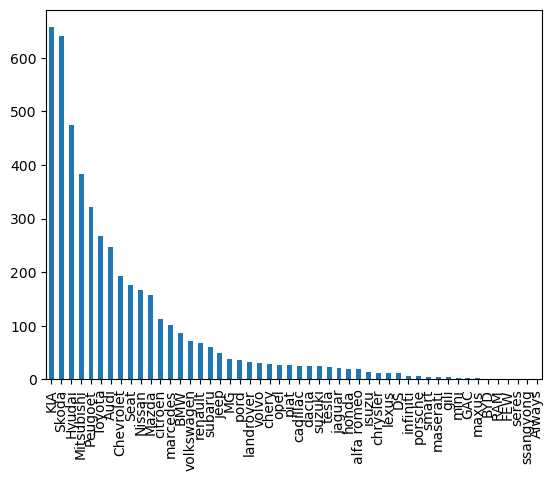

In [124]:
df['company'].value_counts().plot(kind='bar')

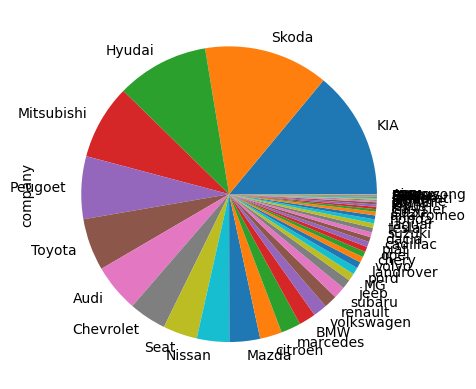

In [125]:

plot = df['company'].value_counts().plot(kind='pie')


<AxesSubplot:ylabel='year'>

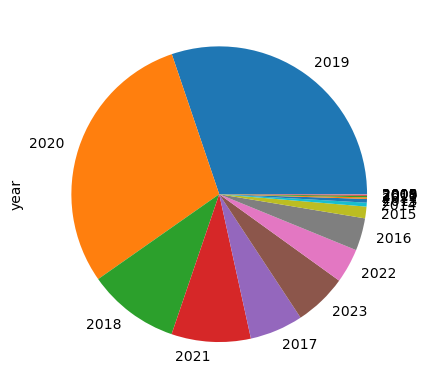

In [126]:
df['year'].value_counts().plot(kind='pie')

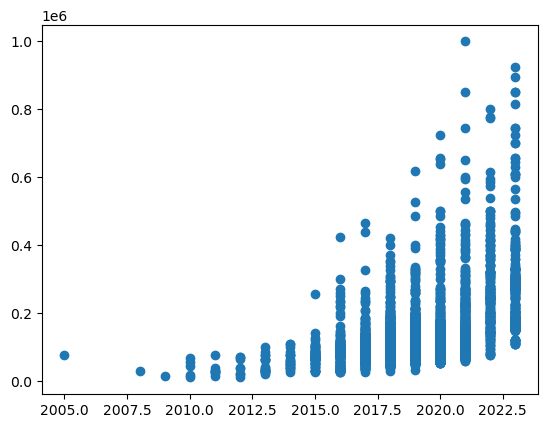

In [127]:
plt.scatter(df.year, df.price)

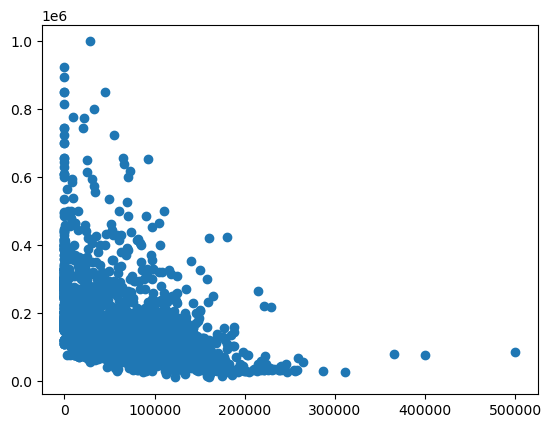

In [128]:
plt.scatter(df.km, df.price)

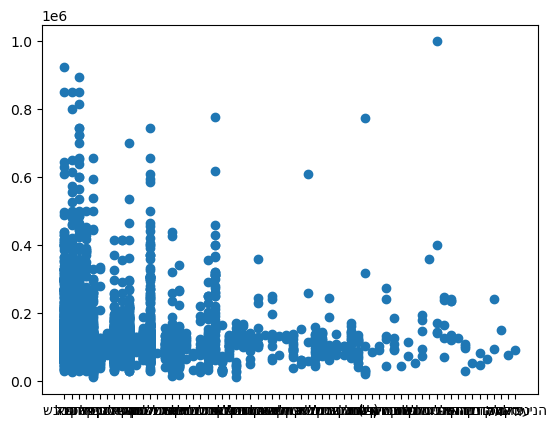

In [129]:
plt.scatter(df.color, df.price)

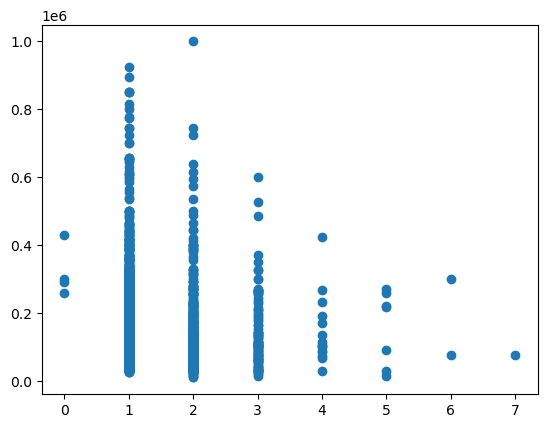

In [130]:
plt.scatter(df.hand, df.price)

## duplicated:

In [131]:
df.duplicated().sum()

108

In [132]:
df[df.duplicated()]

company       car type  year  engine volume      km  hand  gear box  \
180      renault          קליאו  2019           1461   97681     1  אוטומטית   
247        chery             FX  2023           1598       0     1  אוטומטית   
260        Skoda        אוקטביה  2019           1498  106936     1  אוטומטית   
300         Audi             Q3  2023           1498       0     1  אוטומטית   
360       Hyudai          אקסנט  2019           1368   61556     1  אוטומטית   
380        smart          פורטו  2021              0   16000     1  אוטומטית   
400       jaguar         F-PACE  2018           1997  100000     2  אוטומטית   
411       subaru             XV  2023           1995       0     1  אוטומטית   
420        Skoda         קודיאק  2019           1498  135000     1  אוטומטית   
429         Audi             Q3  2023           1498       0     1  אוטומטית   
472        chery             FX  2023           1598       0     1  אוטומטית   
480        Mazda              3  2019           1998   75561     1  אוטומטית   
502     marcedes            CLA  2023           1332       0     1  אוטומטית   
563        chery             FX  2023           1598       0     1  אוטומטית   
580        Skoda        אוקטביה  2019           1498   99456     1  אוטומטית   
600          KIA           נירו  2020           1580  125879     1  אוטומטית   
751        chery             FX  2023           1598       0     1  אוטומטית   
759        chery           טיגו  2023           1598       0     1  אוטומטית   
841     marcedes            CLA  2023           1332       0     1  אוטומטית   
878     marcedes            CLA  2023           1332       0     1  אוטומטית   
1100       dacia          דאסטר  2017           1461  130000     1  אוטומטית   
1103    marcedes            CLA  2023           1332       0     1  אוטומטית   
1120      Hyudai            I10  2019           1248  105045     1  אוטומטית   
1160        jeep         שירוקי  2022           3604       0     1  אוטומטית   
1240   Chevrolet          ספארק  2020           1399   45001     1  אוטומטית   
1272    marcedes            CLA  2023           1332       0     1  אוטומטית   
1320      Toyota         קורולה  2020           1798   84988     1  אוטומטית   
1400      Hyudai          סונטה  2018           1999  121000     2  אוטומטית   
1440       Skoda         קודיאק  2020           1498   51000     1  אוטומטית   
1500      Hyudai            I10  2019           1248   90541     1  אוטומטית   
1542   Chevrolet   טרייל בלייזר  2023           1341       0     1  אוטומטית   
1553        Audi             A4  2023           1984       0     1  אוטומטית   
1560       Mazda              3  2019           1998   44360     1  אוטומטית   
1562        Audi             Q2  2023           1498       0     1  אוטומטית   
1627        Audi             A4  2023           1984       0     1  אוטומטית   
1739    marcedes            CLA  2023           1332       0     1  אוטומטית   
1787        Audi             Q2  2023           1498       0     1  אוטומטית   
1963       chery             FX  2023           1598       0     1  אוטומטית   
2044        Audi             Q3  2023           1498       0     1  אוטומטית   
2055       chery           טיגו  2023           1598       0     1  אוטומטית   
2072      Hyudai          טוסון  2023           1598       0     1  אוטומטית   
2115        Audi             Q3  2023           1498       0     1  אוטומטית   
2142        Audi             A4  2023           1984       0     1  אוטומטית   
2153       chery             FX  2023           1598       0     1  אוטומטית   
2181    marcedes            CLA  2023           1332       0     1  אוטומטית   
2199        Audi             Q2  2023           1498       0     1  אוטומטית   
2341       chery             FX  2023           1598       0     1  אוטומטית   
2370        Audi             Q3  2023           1498       0     1  אוטומטית   
2386       chery             FX  2023           1598       0     1  אוטומטית   
2388     

In [135]:
df.drop_duplicates()
df.shape

(4699, 12)